In [1]:
import sys
sys.path.insert(0, "..")

import os, glob
import yaml
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from cutmix.cutmix import CutMix
from cutmix.utils import CutMixCrossEntropyLoss

from utils.data import CustomImageDataset

In [2]:
#with open('../data.yaml', 'r') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
#    data = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
NUM_CLASSES = 4 #data["num_classes"]
RESUME = False
epochs = 10
IMG_SIZE = 640
BATCH_SIZE = 8
WEIGHTS_DIR = "../weights"
CUTMIX = False

Path(WEIGHTS_DIR).mkdir(exist_ok=True, parents=True)

In [4]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Lambda
from torchvision.transforms import ColorJitter, RandomAffine, RandomPerspective, RandomRotation, RandomErasing, RandomCrop, Grayscale
from torchvision.transforms import RandomChoice, RandomApply

def get_train_grayscale_transforms(img_size: int) -> Compose:
    """Returns data transformations/augmentations for train dataset.
    
    Args:
        img_size: The resolution of the input image (img_size x img_size)
    """
    return Compose([
        RandomApply([
            ColorJitter(brightness=0.3, contrast=0.01, saturation=0.01, hue=0),
            RandomAffine(0.1, translate=(0.04,0.04), scale=(0.04,0.04), shear=0.01, resample=2),
            RandomCrop(30),
            RandomPerspective(0.1)
        ]),
        Resize([img_size, img_size], interpolation=3),
        ToTensor(),
        Normalize(
            mean=[0.5203580774185134],
            std=[0.24102417452995067])
    ])
def get_test_grayscale_transforms(img_size: int) -> Compose:
    """Returns data transformations/augmentations for train dataset.
    
    Args:
        img_size: The resolution of the input image (img_size x img_size)
    """
    return Compose([
        Resize([img_size, img_size], interpolation=3),
        ToTensor(),
        Normalize(
            mean=[0.5203580774185134],
            std=[0.24102417452995067])
    ])

In [5]:
train_imgs = glob.glob("../../../Dataset/Covid19/classification_full_size/classification_full_size/train/*/*.jpg")
valid_imgs = glob.glob("../../../Dataset/Covid19/classification_full_size/classification_full_size/valid/*/*.jpg")
#train_imgs = glob.glob("../../../Dataset/CIFAR-10-images/train/*/*.jpg")
#valid_imgs = glob.glob("../../../Dataset/CIFAR-10-images/test/*/*.jpg")


train_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in train_imgs])
valid_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in valid_imgs])
class_to_idx = {label: idx for idx, label in enumerate(train_labels)}
train_dataset = CustomImageDataset(train_imgs, get_test_grayscale_transforms(IMG_SIZE), train_labels)
if CUTMIX:
    train_dataset = CutMix(train_dataset, num_class=NUM_CLASSES, beta=1.0, prob=0.5, num_mix=2)    # this is paper's original setting for cifar.

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)

valid_dataset = CustomImageDataset(valid_imgs, get_test_grayscale_transforms(IMG_SIZE), valid_labels)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [6]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from utils.models import get_resnet18, get_efficientnetb0

# Using gpu or not
CUDA = "cuda" if torch.cuda.is_available() else "cpu"
if CUDA == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

model = get_efficientnetb0(NUM_CLASSES, num_channels=1)
#model = get_resnet18(NUM_CLASSES)
#model = get_ghostnet(NUM_CLASSES)
model.to(CUDA)
print(list(class_to_idx.keys()))

if RESUME:
    optimizer, criterion = get_training_stuff(model)
else:
    #weights = torch.Tensor(weights).to(CUDA)
    #optimizer, criterion = get_training_stuff(model, weights=weights)
    optimizer = torch.optim.Adam(model.parameters())
    if CUTMIX:
        criterion = CutMixCrossEntropyLoss(True)
    else:
        criterion = torch.nn.CrossEntropyLoss()
    
if RESUME:
    start_epoch = state_dict["epoch"]
    optimizer_state_dict = state_dict["optimizer_state_dict"]
    best_test_f1 = state_dict["best_test_f1"]

    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
else:
    best_test_f1 = 0
    start_epoch = 0

for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0
    t = tqdm(train_dataloader)
    for i, (X, y) in enumerate(t):
        

        X = X.to(CUDA)
        y = y.to(CUDA)

        optimizer.zero_grad()

        preds = model(X)
        loss = criterion(preds, y)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().detach()
        t.set_description(f"{epoch+1}/{epochs} Train: {round(float(running_loss)/(i+1), 4)}")

    model.eval()
    with torch.no_grad():
        predictions = list() # For display purpose
        targets = list() # For display purpose
        if epoch+1 == epochs:
            images = list() # For display purpose
        running_loss = 0
        t = tqdm(valid_dataloader)
        for i, (X, y) in enumerate(t):
            X = X.to(CUDA)
            y = y.to(CUDA)

            preds = model(X)
            predictions += list(preds.argmax(axis=1).cpu().detach().numpy())
            targets += list(np.array(y.cpu()))
            if epoch+1 == epochs:
                images += list(np.array(X.cpu()))
        
            loss = criterion(preds, y)

            running_loss += loss.cpu().detach()
            t.set_description(f"Test: {round(float(running_loss/(i+1)), 4)}")

    acc = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions, average="macro", labels=np.unique(predictions))
    recall = recall_score(targets, predictions, average="macro", labels=np.unique(predictions))
    precision = precision_score(targets, predictions, average="macro", labels=np.unique(predictions))
    print(f"Test: Acc: {str(acc)[:5]}, F1: {str(f1)[:5]}, Recall: {str(recall)[:5]}, Precision: {str(precision)[:5]}\n")

    if f1 > best_test_f1:
        best_test_f1 = f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_test_f1': best_test_f1,
            'train_dataloader': train_dataloader,
            'test_dataloader': valid_dataloader,
            'class_to_idx': class_to_idx
        }, os.path.join(WEIGHTS_DIR, "best.pt"))

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_test_f1': best_test_f1,
    'train_dataloader': train_dataloader,
    'test_dataloader': valid_dataloader,
    'class_to_idx': class_to_idx,
}, os.path.join(WEIGHTS_DIR, "last.pt"))

display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

def show_confusion_matrix(matrix: List[List], labels: List[str]):
    """Display a nice confusion matrix given
    the confusion matrix in a 2D list + list of labels (decoder)
    
    Args:
        matrix: 2D array containing the values to display (confusion matrix)
        labels: Array containing the labels (indexed by corresponding label idx)
    """
    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    min_val, max_val = 0, len(labels)

    for i in range(max_val):
        for j in range(max_val):
            c = matrix[i][j]
            ax.text(i, j, str(int(c)), va='center', ha='center')

    ax.matshow(matrix, cmap=plt.cm.Blues)

    # Set number of ticks for x-axis
    ax.set_xticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_xticklabels(labels, rotation='vertical', fontsize=16)

    # Set number of ticks for x-axis
    ax.set_yticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_yticklabels(labels, rotation='horizontal', fontsize=16)
                    
    #ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val - 0.5, min_val - 0.5)
    plt.show()
    
def display_missclassified(class_to_idx: Dict[str,int], 
                           targets: List[int], 
                           predictions: List[int], 
                           images: List[np.ndarray], 
                           gridsize: Tuple[int] = (4,4)):
    """Display a grid with missclassified samples from test set.
    
    Args:
        class_to_idx: Class to idx encoder
        targets:      List containing all ground truths
        predictions:  List containing all predictions
        images:       List containing image arrays
        gridsize:     Tuple describing the final image grid
    """
    fig = plt.figure()
    plot_counter = 1
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    idx_to_class = {i:label for i, label in enumerate(class_to_idx)}
    for i in range(len(targets)):
        if plot_counter > gridsize[0]*gridsize[1]:
            break
        
        image = images[i].transpose(1, 2, 0)
        image = ((image * std) + mean) * 255
        image = image.astype("uint8")
    
        image = cv2.resize(image, (128, 128))
        image = cv2.putText(image, idx_to_class[predictions[i]], (0,20), 3, 0.4, (0,0,255), 1)
        if predictions[i] == targets[i]:
            pass
        else:
            ax = fig.add_subplot(gridsize[0], gridsize[1], plot_counter)
            ax.imshow(image)
            plot_counter += 1
    plt.show()

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

['indeterminate', 'negative', 'atypical', 'typical']


Test: 0.8808: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [03:13<00:00,  1.20it/s]


Test: Acc: 0.679, F1: 0.713, Recall: 0.816, Precision: 0.635



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.680, F1: 0.696, Recall: 0.752, Precision: 0.662



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.686, F1: 0.373, Recall: 0.428, Precision: 0.423



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.699, F1: 0.375, Recall: 0.419, Precision: 0.362



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.663, F1: 0.373, Recall: 0.423, Precision: 0.400



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.665, F1: 0.367, Recall: 0.429, Precision: 0.353



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.623, F1: 0.392, Recall: 0.431, Precision: 0.448



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.619, F1: 0.407, Recall: 0.441, Precision: 0.413



  0%|                                                                                                                                                                                     | 0/561 [00:00<?, ?it/s]

Test: Acc: 0.607, F1: 0.417, Recall: 0.443, Precision: 0.418



Test: 1.1465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [03:24<00:00,  1.13it/s]


Test: Acc: 0.611, F1: 0.436, Recall: 0.440, Precision: 0.436



NameError: name 'display_missclassified' is not defined

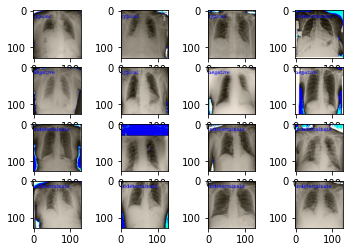

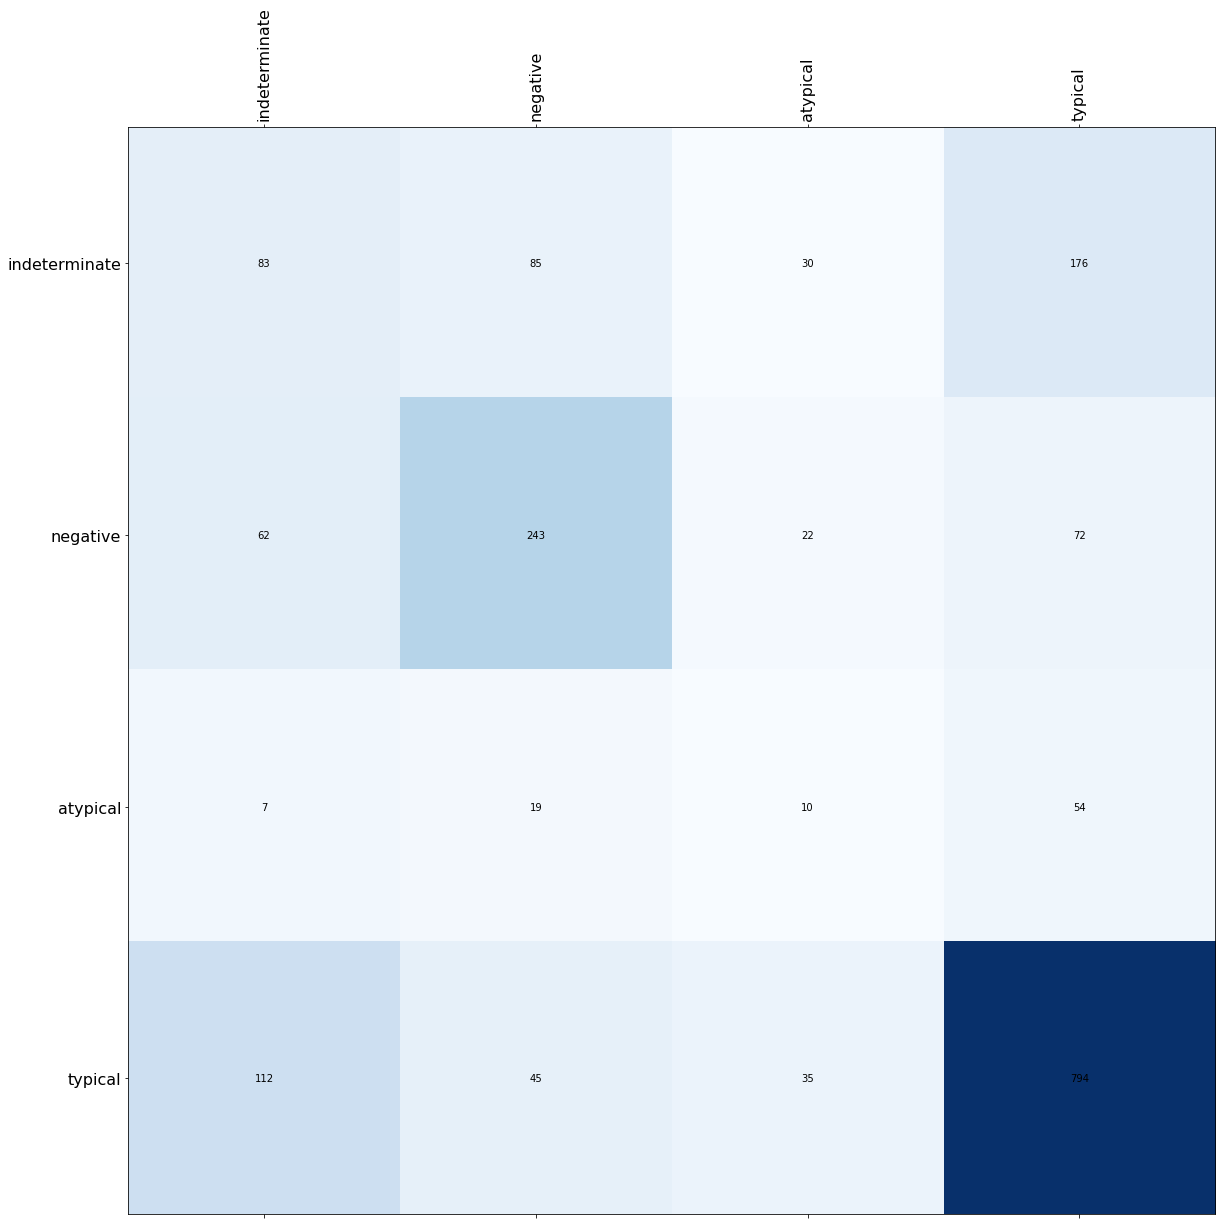

In [14]:
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import cv2

def show_confusion_matrix(matrix: List[List], labels: List[str]):
    """Display a nice confusion matrix given
    the confusion matrix in a 2D list + list of labels (decoder)
    
    Args:
        matrix: 2D array containing the values to display (confusion matrix)
        labels: Array containing the labels (indexed by corresponding label idx)
    """
    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)

    min_val, max_val = 0, len(labels)

    for i in range(max_val):
        for j in range(max_val):
            c = matrix[i][j]
            ax.text(i, j, str(int(c)), va='center', ha='center')

    ax.matshow(matrix, cmap=plt.cm.Blues)

    # Set number of ticks for x-axis
    ax.set_xticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_xticklabels(labels, rotation='vertical', fontsize=16)

    # Set number of ticks for x-axis
    ax.set_yticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_yticklabels(labels, rotation='horizontal', fontsize=16)
                    
    #ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val - 0.5, min_val - 0.5)
    plt.show()
    
def display_missclassified(class_to_idx: Dict[str,int], 
                           targets: List[int], 
                           predictions: List[int], 
                           images: List[np.ndarray], 
                           gridsize: Tuple[int] = (4,4)):
    """Display a grid with missclassified samples from test set.
    
    Args:
        class_to_idx: Class to idx encoder
        targets:      List containing all ground truths
        predictions:  List containing all predictions
        images:       List containing image arrays
        gridsize:     Tuple describing the final image grid
    """
    fig = plt.figure()
    plot_counter = 1
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    idx_to_class = {i:label for i, label in enumerate(class_to_idx)}
    for i in range(len(targets)):
        if plot_counter > gridsize[0]*gridsize[1]:
            break
        
        image = images[i].transpose(1, 2, 0)
        image = ((image * std) + mean) * 255
        image = image.astype("uint8")
    
        image = cv2.resize(image, (128, 128))
        image = cv2.putText(image, idx_to_class[predictions[i]], (0,20), 3, 0.4, (0,0,255), 1)
        if predictions[i] == targets[i]:
            pass
        else:
            ax = fig.add_subplot(gridsize[0], gridsize[1], plot_counter)
            ax.imshow(image)
            plot_counter += 1
    plt.show()
    
display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))


In [18]:
model = get_efficientnetb0(NUM_CLASSES, num_channels=1)
state_dict = torch.load(os.path.join("../weights", "best.pt"))
model.load_state_dict(state_dict["model_state_dict"])     
model.to(CUDA)

model.eval()
with torch.no_grad():
    predictions = list() # For display purpose
    targets = list() # For display purpose
    if epoch+1 == epochs:
        images = list() # For display purpose
    running_loss = 0
    t = tqdm(valid_dataloader)
    for i, (X, y) in enumerate(t):
        X = X.to(CUDA)
        y = y.to(CUDA)

        preds = model(X)
        predictions += list(preds.argmax(axis=1).cpu().detach().numpy())
        targets += list(np.array(y.cpu()))
        if epoch+1 == epochs:
            images += list(np.array(X.cpu()))

        loss = criterion(preds, y)

        running_loss += loss.cpu().detach()
        t.set_description(f"Test: {round(float(running_loss/(i+1)), 4)}")

acc = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions, average="macro", labels=np.unique(predictions))
recall = recall_score(targets, predictions, average="macro", labels=np.unique(predictions))
precision = precision_score(targets, predictions, average="macro", labels=np.unique(predictions))
print(f"Test: Acc: {str(acc)[:5]}, F1: {str(f1)[:5]}, Recall: {str(recall)[:5]}, Precision: {str(precision)[:5]}\n")

Test: 0.883: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [04:28<00:00,  1.16s/it]

Test: Acc: 0.679, F1: 0.713, Recall: 0.816, Precision: 0.635



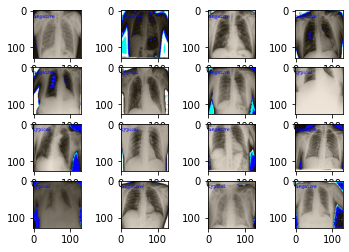

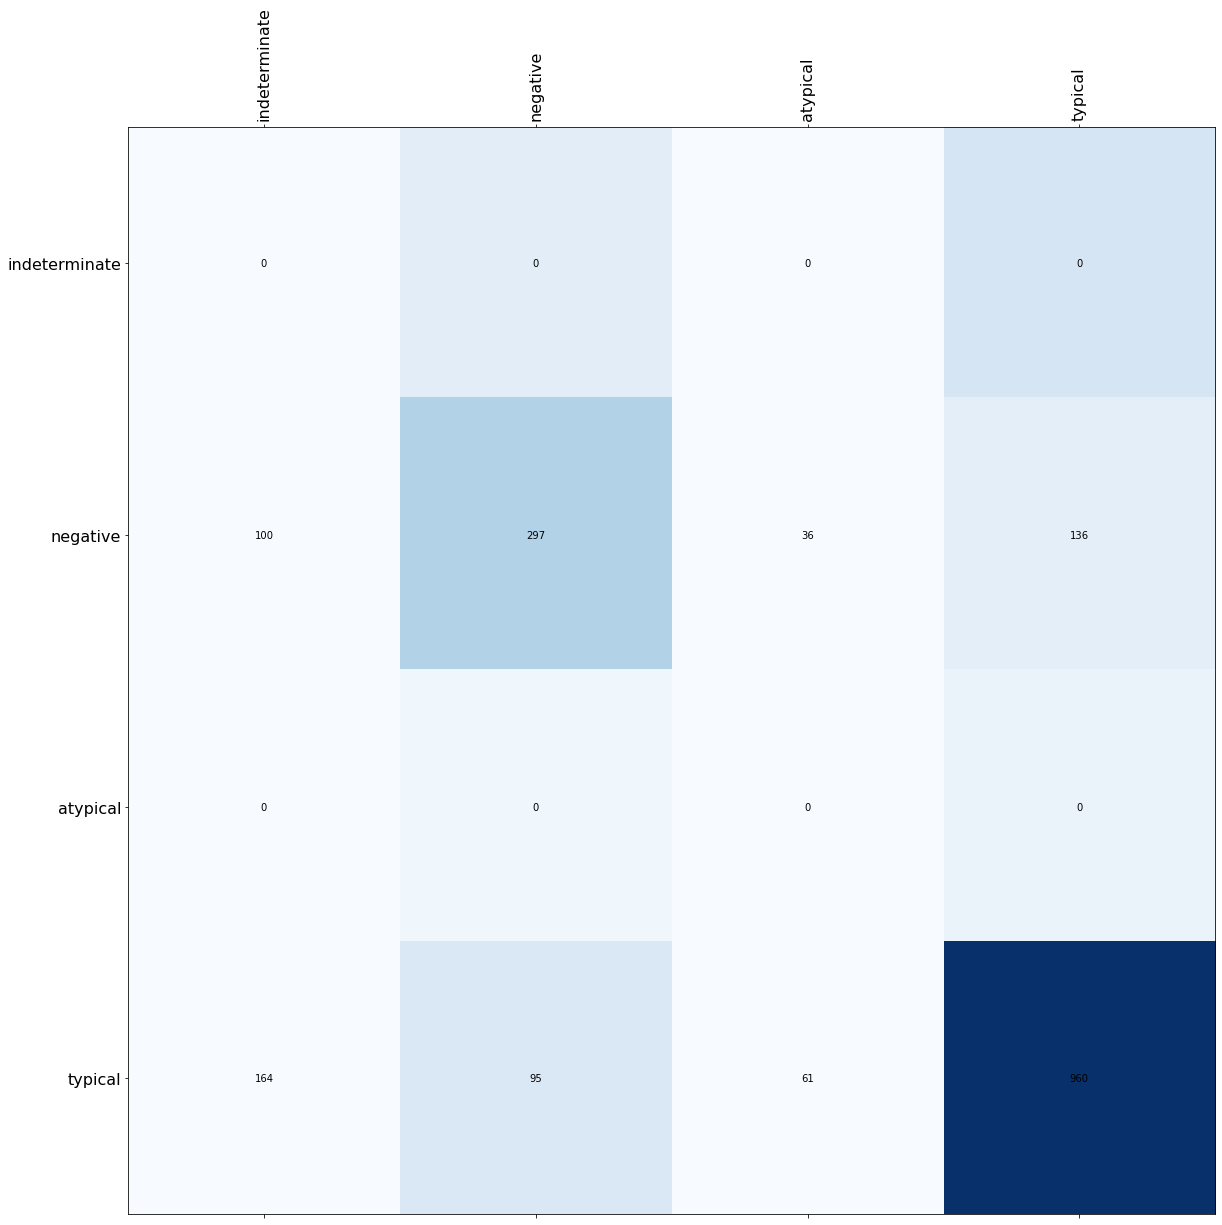

In [19]:
display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

In [ ]:
import plotly.express as px

px.histogram(y=x.flatten())

In [ ]:
import yaml
data = {
    "pixel_mean": 0.5203580774185134,
    "pixel_std": 0.24102417452995067,
    "labels": ['negative', 'typical', 'indeterminate', 'atypical']
}


with open("output_file.yaml", "w") as file:
    yaml.dump(data, file)

In [ ]:
with open(r'output_file.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    fruits_list = yaml.load(file, Loader=yaml.FullLoader)

    print(fruits_list)

In [ ]:
!ls ../../../Datasets/train_test_classification_full_size/train

In [ ]:
for a in data_loader:
    print(a)

In [ ]:
#!dir ..\..\..\Dataset\Covid19\classification_full_size\classification_full_size\train
!dir ..\..\..\Dataset\CIFAR-10-images\